In [1]:
import os
import numpy as np
import pandas as pd
from collections import defaultdict
import gymnasium as gym
from ray.rllib.algorithms.algorithm import Algorithm
from ray.tune.registry import register_env
from tqdm import tqdm

from sustaingym.algorithms.base import RLLibAlgorithm
from sustaingym.envs.evcharging import (
    EVChargingEnv, 
    GMMsTraceGenerator, 
    DiscreteActionWrapper
)
from ray.rllib.algorithms.ppo import PPOConfig
import torch

# Configuration
CHECKPOINT_DIR = "logs/caltech_ppo_Summer 2021_lr0.0005_seed123_both/checkpoint_000050/policies/default_policy/policy_state.pkl"
NUM_ROLLOUTS = 100
SITE = "caltech"
DATE_PERIOD = "Summer 2021"
DATE_RANGE = ("2021-07-05", "2021-07-18")
SEED = 123

print(f"Loading checkpoint from: {CHECKPOINT_DIR}")
print(f"Running {NUM_ROLLOUTS} rollouts...")

/Users/so/miniforge3/envs/sustaingym_ev/lib/python3.10/site-packages/ray/_private/parameter.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-12-07 14:27:05,274	WARNING __init__.py:10 -- PG has/have been moved to `rllib_contrib` and will no longer be maintained by the RLlib team. You can still use it/them normally inside RLlib util Ray 2.8, but from Ray 2.9 on, all `rllib_contrib` algorithms will no longer be part of the core repo, and will therefore have to be installed separately with pinned dependencies for e.g. ray[rllib] and other packages! See https://github.com/ray-project/ray/tree/master/rllib_contrib#rllib-contrib for more information on the RLlib contrib effort.


Loading checkpoint from: logs/caltech_ppo_Summer 2021_lr0.0005_seed123_both/checkpoint_000050/policies/default_policy/policy_state.pkl
Running 100 rollouts...


In [2]:
class MOERForecastWrapper(gym.ObservationWrapper):
    def __init__(self, env, std_table_path, bias_table_path):
        super().__init__(env)
        
        # 1. Load your pre-computed table
        # We assume this is a dictionary or array keyed by 5-min intervals (0 to 287)
        # shape: (288, forecast_horizon)
        # For this example, I'll generate a random one
        self.forecast_horizon = 36  # Default for Summer 2021
        self.error_std_table = pd.read_csv(std_table_path, header = 0, index_col=0)
        self.error_bias_table = pd.read_csv(bias_table_path, header = 0, index_col=0)

        # 2. Update the observation space
        # We need to tell RLLib the observation is now bigger.
        # The base env usually outputs a Dict. We assume we are wrapping BEFORE Flatten.
        
        # We need to know the shape of the original MOER forecast to append correctly.
        # In SustainGym, the obs is a Dictionary. We will add a new key.
        self.observation_space = env.observation_space
        
        # Define the space for our new error vector
        self.observation_space['moer_forecast_std'] = gym.spaces.Box(
            low=0, 
            high=np.inf, 
            shape=(self.forecast_horizon,), 
            dtype=np.float32
        )

        self.observation_space['moer_forecast_bias'] = gym.spaces.Box(
            low=-np.inf, 
            high=np.inf, 
            shape=(self.forecast_horizon,), 
            dtype=np.float32
        )

    def timestep_to_index(self, ts):
        return int(np.round((ts * 60 * 24) / 5)) - 1

    def observation(self, obs):
        """
        This method is called every time the env returns an observation.
        """
        # 1. Get the time of day from the observation
        
        t_fraction = obs['timestep'] 
        time_index = self.timestep_to_index(t_fraction)
        
        # 2. Lookup the pre-computed error vector
        error_std_vector = self.error_std_table.iloc[time_index].values
        error_bias_vector = self.error_bias_table.iloc[time_index].values
        
        # 3. Add it to the observation dictionary
        # We return a copy so we don't mutate the original in place unexpectedly
        new_obs = obs.copy()
        new_obs['moer_forecast_std'] = error_std_vector
        new_obs['moer_forecast_bias'] = error_bias_vector
        
        return new_obs


In [4]:
def make_env(dp: str, site: str, seed: int):
    if dp != "Summer 2021":
        raise ValueError("This minimal script only supports Summer 2021.")

    date_range = ("2021-07-05", "2021-07-18")
    
    # 1. Base Environment
    gen = GMMsTraceGenerator(site, date_range, seed=seed)
    env = EVChargingEnv(gen)
    
    # This adds the error vector to the dictionary
    env = MOERForecastWrapper(env, std_table_path="../moer_errors/error_std.csv", bias_table_path="../moer_errors/error_bias.csv")
    
    # 3. Flatten at the very end
    # FlattenObservation will automatically flatten the new 'moer_forecast_error' 
    # key along with the rest, making it visible to the PPO agent.
    return gym.wrappers.FlattenObservation(env)

register_env(
        "evcharging",
        lambda config: make_env("Summer 2021", "caltech", 123),)

train_config = (
    PPOConfig()
    .environment(env="evcharging")
    .rollouts(num_rollout_workers=0)  # Match training config
    .framework("torch")
)

algo = train_config.build(env="evcharging")

# Load policy weights directly from module_state.pt
module_state_path = os.path.join(
    CHECKPOINT_DIR, 
    "learner", 
    "module_state", 
    "default_policy", 
    "module_state_dir", 
    "module_state.pt"
)

if os.path.exists(module_state_path):
    print(f"Loading policy weights from: {module_state_path}")
    policy = algo.get_policy()
    
    state_dict = torch.load(module_state_path, map_location="cpu")
    
    # The state dict might have a nested structure, so we need to extract the model weights
    # For RLLib policies, the model is usually at the top level or nested
    if isinstance(state_dict, dict):
        # Try to find model weights - they might be under different keys
        # Common patterns: direct keys, or nested under 'model' or similar
        model_state = {}
        for key, value in state_dict.items():
            # Skip non-model keys (like optimizer state, etc.)
            if not any(skip in key.lower() for skip in ['optimizer', 'scheduler', 'step', 'epoch']):
                model_state[key] = value
        
        # Load into policy model
        try:
            policy.model.load_state_dict(model_state, strict=False)
            print("Successfully loaded policy weights!")
        except Exception as e:
            print(f"Warning: Could not load all weights: {e}")
            # Try loading with strict=False to allow partial loading
            try:
                policy.model.load_state_dict(state_dict, strict=False)
                print("Loaded weights with strict=False (some weights may not match)")
            except Exception as e2:
                print(f"Failed to load weights: {e2}")
                raise
    else:
        # If it's not a dict, try loading directly
        policy.model.load_state_dict(state_dict, strict=False)
        print("Successfully loaded policy weights!")
else:
    print(f"Warning: Module state file not found at {module_state_path}")
    print("Attempting to use algorithm without loading weights...")

print("Algorithm ready!")
print(f"Algorithm type: {type(algo)}")

2025-12-07 14:27:39,434	WARNING env.py:162 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2025-12-07 14:27:39,701	WARNING util.py:62 -- Install gputil for GPU system monitoring.


Attempting to use algorithm without loading weights...
Algorithm ready!
Algorithm type: <class 'ray.rllib.algorithms.ppo.ppo.PPO'>


In [5]:
# Create environment and algorithm wrapper
env = make_env("Summer 2021", "caltech", 123)
rllib_algo = RLLibAlgorithm(env, algo, multiagent=False)

# Storage for metrics
all_rewards = []
all_profits = []  # Power delivery (profit component)
all_carbon_costs = []  # Carbon cost component
all_constraint_violations = []  # Constraint violation cost component
power_by_hour = defaultdict(list)  # hour -> list of total power (Amps) at that hour
moer_by_hour = defaultdict(list)  # hour -> list of MOER values at that hour
demand_by_station_by_hour = defaultdict(lambda: defaultdict(list))  # station_idx -> hour -> list of demands (kWh)

# Store individual rollout data for finding high evening demand rollouts
individual_rollout_demands = []  # List of dicts: {rollout_idx, demand_by_hour, power_by_hour, moer_by_hour}

print("Starting rollouts...")

Starting rollouts...


In [7]:
# Run rollouts sequentially
print(f"Running {NUM_ROLLOUTS} rollouts sequentially...")

for rollout_idx in tqdm(range(NUM_ROLLOUTS), desc="Running rollouts"):
    obs, _ = env.reset(seed=rollout_idx)
    rllib_algo.reset()
    
    episode_reward = 0.0
    episode_power_by_timestep = []
    episode_moer_by_timestep = []
    episode_demands_by_timestep = []
    
    done = False
    
    while not done:
        # Get action from policy
        action = rllib_algo.get_action(obs)
        
        # Step environment
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        episode_reward += reward
        
        # Collect power profile data
        # Access the simulator's charging rates
        # Unwrap: DiscreteActionWrapper -> FlattenObservation -> EVChargingEnv
        actual_env = env.env.env  # Get the actual EVChargingEnv
        if hasattr(actual_env, '_simulator') and hasattr(actual_env, 't'):
            # Get charging rates for current timestep
            # t is already incremented in step(), so current timestep is t-1
            current_timestep = actual_env.t - 1
            if current_timestep >= 0 and current_timestep < actual_env._simulator.charging_rates.shape[1]:
                total_power = np.sum(actual_env._simulator.charging_rates[:, current_timestep])
                episode_power_by_timestep.append(total_power)
        
        # Collect MOER data from environment
        # Get MOER from environment's moer array (shape [289, 37])
        if hasattr(actual_env, 'moer') and hasattr(actual_env, 't'):
            current_timestep = actual_env.t - 1
            if current_timestep >= 0 and current_timestep < actual_env.moer.shape[0]:
                moer_value = actual_env.moer[current_timestep, 0]  # Current timestep's MOER
                episode_moer_by_timestep.append(moer_value)
        
        # Collect demand data per station
        # Demands are in the environment's _demands array (shape [num_stations])
        if hasattr(actual_env, '_demands'):
            demands = actual_env._demands.copy()  # Copy to avoid reference issues
            episode_demands_by_timestep.append(demands)
    
    all_rewards.append(episode_reward)
    
    # Collect reward breakdown components at end of episode
    # The reward_breakdown is cumulative over the episode
    actual_env = env.env.env  # Get the actual EVChargingEnv
    if hasattr(actual_env, '_reward_breakdown'):
        reward_breakdown = actual_env._reward_breakdown
        episode_profit = reward_breakdown.get('profit', 0.0)
        episode_carbon_cost = reward_breakdown.get('carbon_cost', 0.0)
        episode_constraint_violation = reward_breakdown.get('excess_charge', 0.0)
        
        all_profits.append(episode_profit)
        all_carbon_costs.append(episode_carbon_cost)
        all_constraint_violations.append(episode_constraint_violation)
    else:
        # Fallback: try to get from info dict (if available at last step)
        # This is a fallback, but info dict might not be available after episode ends
        all_profits.append(0.0)
        all_carbon_costs.append(0.0)
        all_constraint_violations.append(0.0)
    
    # Convert timesteps to hours of day and aggregate
    # Each timestep is 5 minutes, so 12 timesteps = 1 hour
    # timestep 0 = midnight, timestep 288 = next midnight
    for ts_idx, power in enumerate(episode_power_by_timestep):
        hour_of_day = (ts_idx * 5) / 60  # Convert 5-min timesteps to hours
        hour_of_day = int(hour_of_day) % 24  # Ensure 0-23 range
        power_by_hour[hour_of_day].append(power)
    
    # Aggregate MOER by hour
    for ts_idx, moer in enumerate(episode_moer_by_timestep):
        hour_of_day = (ts_idx * 5) / 60  # Convert 5-min timesteps to hours
        hour_of_day = int(hour_of_day) % 24  # Ensure 0-23 range
        moer_by_hour[hour_of_day].append(moer)
    
    # Aggregate demands by station and hour
    for ts_idx, demands in enumerate(episode_demands_by_timestep):
        hour_of_day = (ts_idx * 5) / 60  # Convert 5-min timesteps to hours
        hour_of_day = int(hour_of_day) % 24  # Ensure 0-23 range
        for station_idx, demand in enumerate(demands):
            demand_by_station_by_hour[station_idx][hour_of_day].append(demand)
    
    # Store individual rollout data (aggregated across stations by hour)
    rollout_demand_by_hour = defaultdict(list)
    rollout_power_by_hour = defaultdict(list)
    rollout_moer_by_hour = defaultdict(list)
    
    for ts_idx, demands in enumerate(episode_demands_by_timestep):
        hour_of_day = (ts_idx * 5) / 60  # Convert 5-min timesteps to hours
        hour_of_day = int(hour_of_day) % 24  # Ensure 0-23 range
        # Sum demand across all stations for this timestep
        total_demand = np.sum(demands)
        rollout_demand_by_hour[hour_of_day].append(total_demand)
        
        # Store power and MOER for this timestep
        if ts_idx < len(episode_power_by_timestep):
            rollout_power_by_hour[hour_of_day].append(episode_power_by_timestep[ts_idx])
        if ts_idx < len(episode_moer_by_timestep):
            rollout_moer_by_hour[hour_of_day].append(episode_moer_by_timestep[ts_idx])
    
    # Calculate average per hour for this rollout
    rollout_avg_demand_by_hour = {}
    rollout_avg_power_by_hour = {}
    rollout_avg_moer_by_hour = {}
    
    for hour in range(24):
        if hour in rollout_demand_by_hour and len(rollout_demand_by_hour[hour]) > 0:
            rollout_avg_demand_by_hour[hour] = np.mean(rollout_demand_by_hour[hour])
        else:
            rollout_avg_demand_by_hour[hour] = 0.0
        
        if hour in rollout_power_by_hour and len(rollout_power_by_hour[hour]) > 0:
            rollout_avg_power_by_hour[hour] = np.mean(rollout_power_by_hour[hour])
        else:
            rollout_avg_power_by_hour[hour] = 0.0
        
        if hour in rollout_moer_by_hour and len(rollout_moer_by_hour[hour]) > 0:
            rollout_avg_moer_by_hour[hour] = np.mean(rollout_moer_by_hour[hour])
        else:
            rollout_avg_moer_by_hour[hour] = 0.0
    
    individual_rollout_demands.append({
        'rollout_idx': rollout_idx,
        'demand_by_hour': rollout_avg_demand_by_hour,
        'power_by_hour': rollout_avg_power_by_hour,
        'moer_by_hour': rollout_avg_moer_by_hour
    })

print(f"Completed {NUM_ROLLOUTS} rollouts!")

Running 100 rollouts sequentially...


Running rollouts: 100%|██████████| 100/100 [04:00<00:00,  2.40s/it]

Completed 100 rollouts!


In [8]:
# Calculate average reward
avg_reward = np.mean(all_rewards)
std_reward = np.std(all_rewards)
min_reward = np.min(all_rewards)
max_reward = np.max(all_rewards)

print("=" * 60)
print("METRICS SUMMARY")
print("=" * 60)
print(f"Average Reward: ${avg_reward:.2f}")
print(f"Std Reward: ${std_reward:.2f}")
print(f"Min Reward: ${min_reward:.2f}")
print(f"Max Reward: ${max_reward:.2f}")
print(f"Number of Rollouts: {NUM_ROLLOUTS}")
print("=" * 60)

METRICS SUMMARY
Average Reward: $1.82
Std Reward: $0.94
Min Reward: $0.32
Max Reward: $4.41
Number of Rollouts: 100


In [9]:
# Calculate disaggregated reward components
avg_profit = np.mean(all_profits) if len(all_profits) > 0 else 0.0
avg_carbon_cost = np.mean(all_carbon_costs) if len(all_carbon_costs) > 0 else 0.0
avg_constraint_violation = np.mean(all_constraint_violations) if len(all_constraint_violations) > 0 else 0.0
avg_total_reward = np.mean(all_rewards)

# Create table for disaggregated rewards
reward_breakdown_data = {
    'Algorithm': ['PPO'],
    'Avg. Power Delivery': [f'{avg_profit:.4f}'],
    'Avg. Carbon Cost': [f'{avg_carbon_cost:.4f}'],
    'Avg. Constr. Violation': [f'{avg_constraint_violation:.4f}'],
    'Avg. Total Reward': [f'{avg_total_reward:.4f}']
}

reward_breakdown_df = pd.DataFrame(reward_breakdown_data)

print("\n" + "=" * 80)
print("=" * 80)
print(reward_breakdown_df.to_string(index=False))
print("=" * 80)
print(f"\nNote: Power Delivery (profit) is positive, Carbon Cost and Constraint Violation are costs (negative in reward)")
print(f"Total Reward = Power Delivery - Carbon Cost - Constraint Violation")
print(f"Verification: {avg_profit:.4f} - {avg_carbon_cost:.4f} - {avg_constraint_violation:.4f} = {avg_profit - avg_carbon_cost - avg_constraint_violation:.4f}")
print(f"Actual Average Total Reward: {avg_total_reward:.4f}")


Algorithm Avg. Power Delivery Avg. Carbon Cost Avg. Constr. Violation Avg. Total Reward
      PPO              2.7243           0.9072                 0.0000            1.8171

Note: Power Delivery (profit) is positive, Carbon Cost and Constraint Violation are costs (negative in reward)
Total Reward = Power Delivery - Carbon Cost - Constraint Violation
Verification: 2.7243 - 0.9072 - 0.0000 = 1.8171
Actual Average Total Reward: 1.8171


In [12]:
# Calculate power profile by time of day
power_profile_data = []
for hour in range(24):
    if hour in power_by_hour:
        avg_power = np.mean(power_by_hour[hour])
        std_power = np.std(power_by_hour[hour])
        power_profile_data.append({
            'hour': hour,
            'avg_power_amps': avg_power,
            'std_power_amps': std_power,
            'num_samples': len(power_by_hour[hour])
        })
    else:
        power_profile_data.append({
            'hour': hour,
            'avg_power_amps': 0.0,
            'std_power_amps': 0.0,
            'num_samples': 0
        })

power_profile_df = pd.DataFrame(power_profile_data)

# Calculate MOER profile by time of day
moer_profile_data = []
for hour in range(24):
    if hour in moer_by_hour:
        avg_moer = np.mean(moer_by_hour[hour])
        std_moer = np.std(moer_by_hour[hour])
        moer_profile_data.append({
            'hour': hour,
            'avg_moer': avg_moer,
            'std_moer': std_moer,
            'num_samples': len(moer_by_hour[hour])
        })
    else:
        moer_profile_data.append({
            'hour': hour,
            'avg_moer': 0.0,
            'std_moer': 0.0,
            'num_samples': 0
        })

moer_profile_df = pd.DataFrame(moer_profile_data)

print("\nPower Profile by Time of Day:")
print(power_profile_df.to_string(index=False))
print("\nMOER Profile by Time of Day:")
print(moer_profile_df.to_string(index=False))


Power Profile by Time of Day:
 hour  avg_power_amps  std_power_amps  num_samples
    0        0.000000        0.000000         1200
    1        0.000000        0.000000         1200
    2        0.000000        0.000000         1200
    3        0.000000        0.000000         1200
    4        0.025833        0.640442         1200
    5        1.005000        4.598185         1200
    6        4.595603        9.113723         1200
    7       12.081120       14.649594         1200
    8       21.911741       19.262623         1200
    9       27.960141       22.472305         1200
   10       49.885522       34.646917         1200
   11       65.366195       40.579437         1200
   12       61.997089       38.833300         1200
   13       58.543804       36.612685         1200
   14       56.479691       37.349561         1200
   15       45.386744       34.158375         1200
   16       27.150048       22.527614         1200
   17       14.550285       15.927632         1200


Selected rollout 30 with evening demand: 387.02 kWh


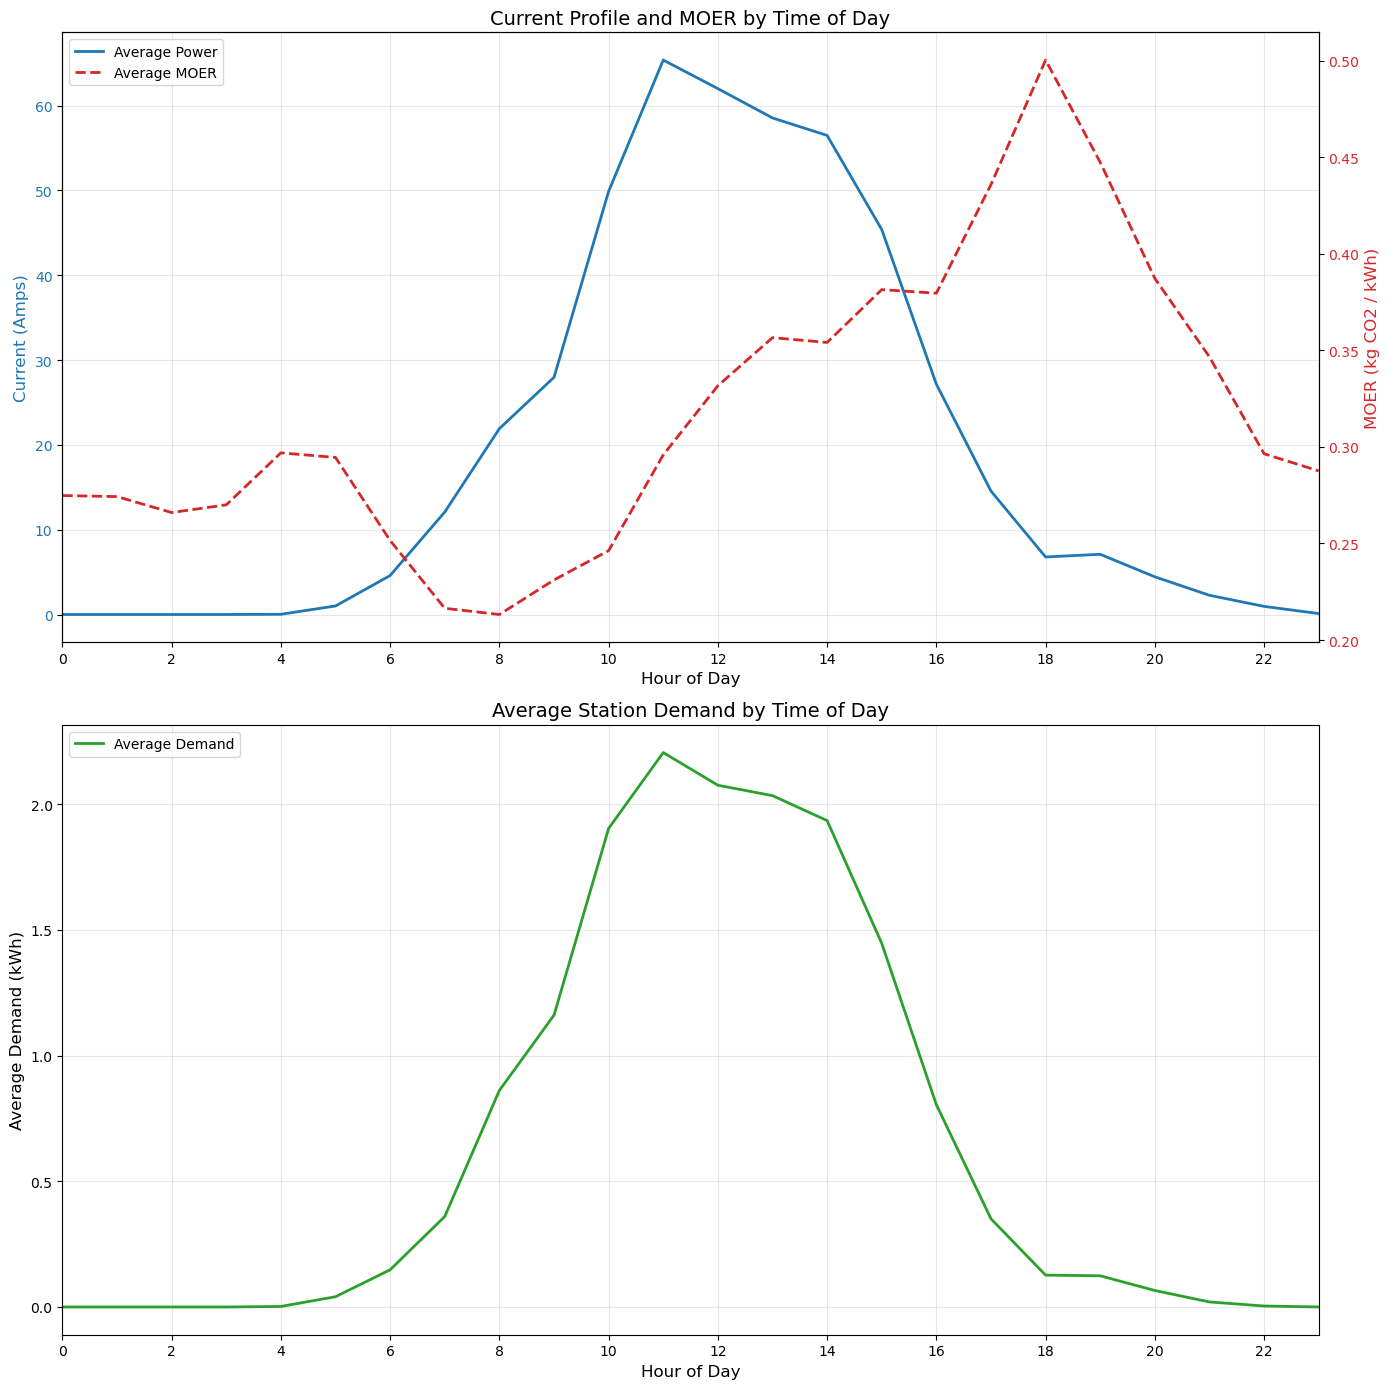


Average total power across all hours: 19.52 Amps
Average MOER across all hours: 0.3182 kg CO2 / kWh
Average demand across all stations and hours: 0.65 kWh
Peak demand hour: 11:00 (2.21 kWh)


In [13]:
# Visualize power profile, MOER, and station demand
import matplotlib.pyplot as plt
import seaborn as sns

# Find a rollout with high evening demand (hours 16-22)
evening_hours = list(range(16, 23))  # 4 PM to 10 PM
rollout_evening_demands = []
for rollout_data in individual_rollout_demands:
    evening_demand = sum(rollout_data['demand_by_hour'].get(hour, 0.0) for hour in evening_hours)
    rollout_evening_demands.append({
        'rollout_idx': rollout_data['rollout_idx'],
        'evening_demand': evening_demand,
        'demand_by_hour': rollout_data['demand_by_hour']
    })

# Sort by evening demand and pick the one with highest evening demand
rollout_evening_demands.sort(key=lambda x: x['evening_demand'], reverse=True)
high_evening_rollout = rollout_evening_demands[0]

print(f"Selected rollout {high_evening_rollout['rollout_idx']} with evening demand: {high_evening_rollout['evening_demand']:.2f} kWh")

# Create figure with three subplots
fig = plt.figure(figsize=(14, 14))

# Top subplot: Power and MOER
ax1 = plt.subplot(2, 1, 1)
hours = power_profile_df['hour']
avg_power = power_profile_df['avg_power_amps']
std_power = power_profile_df['std_power_amps']
avg_moer = moer_profile_df['avg_moer']
std_moer = moer_profile_df['std_moer']

# Plot power on left y-axis
color1 = 'tab:blue'
ax1.set_xlabel('Hour of Day', fontsize=12)
ax1.set_ylabel('Current (Amps)', fontsize=12, color=color1)
line1 = ax1.plot(hours, avg_power, color=color1, linewidth=2, label='Average Power')
# ax1.fill_between(hours, avg_power - std_power, avg_power + std_power, 
#                 alpha=0.3, color=color1, label='Power ±1 Std Dev')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xticks(range(0, 24, 2))
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 23)

# Plot MOER on right y-axis
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color2 = 'tab:red'
ax2.set_ylabel('MOER (kg CO2 / kWh)', fontsize=12, color=color2)
line2 = ax2.plot(hours, avg_moer, color=color2, linewidth=2, linestyle='--', label='Average MOER')
# ax2.fill_between(hours, avg_moer - std_moer, avg_moer + std_moer, 
#                 alpha=0.2, color=color2, label='MOER ±1 Std Dev')
ax2.tick_params(axis='y', labelcolor=color2)

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

ax1.set_title(f'Current Profile and MOER by Time of Day', fontsize=14)

# Bottom subplot: Station demand over time (time series)
ax3 = plt.subplot(2, 1, 2)

# Calculate average demand across all stations for each hour
demand_by_hour_avg = []
demand_by_hour_std = []

for hour in range(24):
    # Collect all demand values for this hour across all stations
    hour_demands = []
    for station_idx in demand_by_station_by_hour:
        if hour in demand_by_station_by_hour[station_idx]:
            hour_demands.extend(demand_by_station_by_hour[station_idx][hour])
    
    if hour_demands:
        demand_by_hour_avg.append(np.mean(hour_demands))
        demand_by_hour_std.append(np.std(hour_demands))
    else:
        demand_by_hour_avg.append(0.0)
        demand_by_hour_std.append(0.0)

# Create time series plot
ax3.plot(hours, demand_by_hour_avg, color='tab:green', linewidth=2, label='Average Demand')
# ax3.fill_between(hours, 
#                  np.array(demand_by_hour_avg) - np.array(demand_by_hour_std),
#                  np.array(demand_by_hour_avg) + np.array(demand_by_hour_std),
#                  alpha=0.3, color='tab:green', label='±1 Std Dev')

ax3.set_xlabel('Hour of Day', fontsize=12)
ax3.set_ylabel('Average Demand (kWh)', fontsize=12)
ax3.set_title(f'Average Station Demand by Time of Day', fontsize=14)
ax3.set_xticks(range(0, 24, 2))
ax3.set_xticklabels(range(0, 24, 2))
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, 23)
ax3.legend(loc='upper left')

plt.tight_layout()
plt.show()

print(f"\nAverage total power across all hours: {avg_power.mean():.2f} Amps")
print(f"Average MOER across all hours: {avg_moer.mean():.4f} kg CO2 / kWh")
print(f"Average demand across all stations and hours: {np.mean(demand_by_hour_avg):.2f} kWh")
print(f"Peak demand hour: {np.argmax(demand_by_hour_avg)}:00 ({max(demand_by_hour_avg):.2f} kWh)")